In [5]:
import os

import matplotlib.patches as patches
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec
import matplotlib.lines as mlines
import geopandas as gpd

COMMON_MODEL = ['CMCC-ESM2', 'CESM2-WACCM','NorESM2-MM', 'TaiESM1', 'EC-Earth3-Veg','CMCC-CM2-SR5', 'BCC-CSM2-MR']
OBSERVATION_INPUT_PATH = "E:/Drought_And_SOC/000_observasion_data_ERA5"
MODEL_INPUT_PATH = "F:/007_CorrectAndRepair_data_CMIP6"
MMEM_INPUT_PATH = "F:/007-1_MEM_data_CMIP6/raw"
MMWM_INPUT_PATH = "F:/007-2_MMWM_data_CMIP6/raw"
OUTPUT_PATH = "E:/Drought_And_SOC/res/figs/Supplementary"

# 定义统一的样式字典
MODEL_STYLES = {
    'MMEM': {'color': 'red', 'linewidth': 2, 'linestyle': '-', 'label': 'MMEM', 'zorder': 15},
    'MMWM': {'color': 'blue', 'linewidth': 2, 'linestyle': ':', 'label': 'MMWM', 'zorder': 20},
    'ERA5': {'color': 'black', 'linewidth': 3, 'linestyle': '--', 'label': 'ERA5', 'zorder': 10},
    'OTHER': {'color': 'gray', 'alpha': 0.5, 'linestyle': '-.', 'linewidth': 1.5, 'label': 'Other Models', 'zorder': 5}
}

OBS_CAL_PATH_POST = {
    'rh': "01_preprocessed_data/merged_rh_data.nc",
    'soc': "01_preprocessed_data/merged_csoil_data.csv",
}

OBS_CAL_VAR = {
    'rh': "Rh",
    'soc': "cSoil"
}

YLABLE_TEXT = {
    'rh': "$R_h$ (kg C $m^{-2}$ $yr^{-1}$)",
    'soc': "$SOC$ (kg C $m^{-2}$)"
}

CONTINENT_DICT = {
    'Asia': 0,
    'North America': 1,
    'Europe': 2,
    'Africa': 3,
    'South America': 4,
    'Oceania': 5
}

In [6]:
def plot_supplementary_fig3a(fig, ax, cal, continent, observation=None):
    cal_MMEM = xr.open_dataset(f"{MMEM_INPUT_PATH}/{cal}_MMEM.nc")[f'ssp126_{cal}'].sel(time=slice('1985-01-01', '2014-12-31'))
    cal_MMWM = xr.open_dataset(f"{MMWM_INPUT_PATH}/{cal}_MMWM.nc")[f'ssp126_{cal}'].sel(time=slice('1985-01-01', '2014-12-31'))

    # cal_obs = xr.open_dataset(f"{OBSERVATION_INPUT_PATH}/{OBS_CAL_PATH_POST[cal]}")[OBS_CAL_VAR[cal]]

    continent_index = CONTINENT_DICT[continent]
    shp_data = gpd.read_file(r"E:/Drought_And_SOC/001_shape_data_GIS/continent.shp")

    # 确定实际的空间维度名称（根据你的数据集）
    x_dim = 'lon'  # 替换为你的数据中经度维度的实际名称
    y_dim = 'lat'  # 替换为你的数据中纬度维度的实际名称

    # 显式设置空间维度
    cal_MMEM.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    cal_MMWM.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    # cal_obs.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)

    # 写入坐标系信息
    cal_MMEM.rio.write_crs(shp_data.crs, inplace=True)
    cal_MMWM.rio.write_crs(shp_data.crs, inplace=True)
    # cal_obs.rio.write_crs(shp_data.crs, inplace=True)

    # 获取要裁剪的几何形状
    shp = shp_data.iloc[continent_index]['geometry']

    cal_MMEM = cal_MMEM.rio.clip([shp], shp_data.crs, drop=False)
    cal_MMWM = cal_MMWM.rio.clip([shp], shp_data.crs, drop=False)
    # cal_obs = cal_obs.rio.clip([shp], shp_data.crs, drop=False)

    cal_MMEM = cal_MMEM.mean(dim=['lat', 'lon'])
    cal_MMWM = cal_MMWM.mean(dim=['lat', 'lon'])
    # cal_obs = cal_obs.mean(dim=['lat', 'lon'])

    cal_model = {}
    for model in COMMON_MODEL:
        cal_tmp = xr.open_dataset(f"{MODEL_INPUT_PATH}/{model}/{model}_SeasonAndLand_corrected_{cal}.nc")[f'ssp126_{cal}'].sel(time=slice('1985-01-01', '2014-12-31'))
        if cal == 'rh':
            cal_tmp = cal_tmp * (60 * 60 * 24 * 365)
        cal_tmp.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
        cal_tmp.rio.write_crs(shp_data.crs, inplace=True)
        cal_tmp = cal_tmp.rio.clip([shp], shp_data.crs, drop=False)
        cal_tmp = cal_tmp.mean(dim=['lat', 'lon'])

        cal_model[model] = cal_tmp

    # 绘制多模型集合和观测数据
    ax.plot(cal_MMEM.time, cal_MMEM.values, **MODEL_STYLES['MMEM'])
    ax.plot(cal_MMWM.time, cal_MMWM.values, **MODEL_STYLES['MMWM'])

    if observation is not None:
        cal_obs = xr.open_dataset(f"{observation}")['rh_mean'].sel(time=slice('1985-01-01', '2014-12-31'))
        cal_obs.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
        cal_obs.rio.write_crs(shp_data.crs, inplace=True)
        cal_obs = cal_obs.rio.clip([shp], shp_data.crs, drop=False)
        cal_obs = cal_obs.mean(dim=['lat', 'lon'])
        ax.plot(cal_obs.time, cal_obs.values, **MODEL_STYLES['ERA5'])

    for model, data in cal_model.items():
        ax.plot(data.time, data.values, **MODEL_STYLES['OTHER'])

    if continent != 'Oceania':
        ax.set_title(f"{continent}", fontsize=20)
    else:
        ax.set_title(f"Australia", fontsize=20)

    if continent == 'North America' or continent == 'Africa' or continent == 'Oceania':
        ax.set_ylabel("")
    else:
        ax.set_ylabel(YLABLE_TEXT[cal], fontsize=20)

    if continent == 'South America' or continent == 'Oceania':
        ax.set_xlabel('Year', fontsize=20)
    else:
        ax.set_xlabel("")

    ax.tick_params(axis='x', labelsize=16)  # 设置 x 轴刻度字体大小
    ax.tick_params(axis='y', labelsize=16)  # 设置 y 轴刻度字体大小

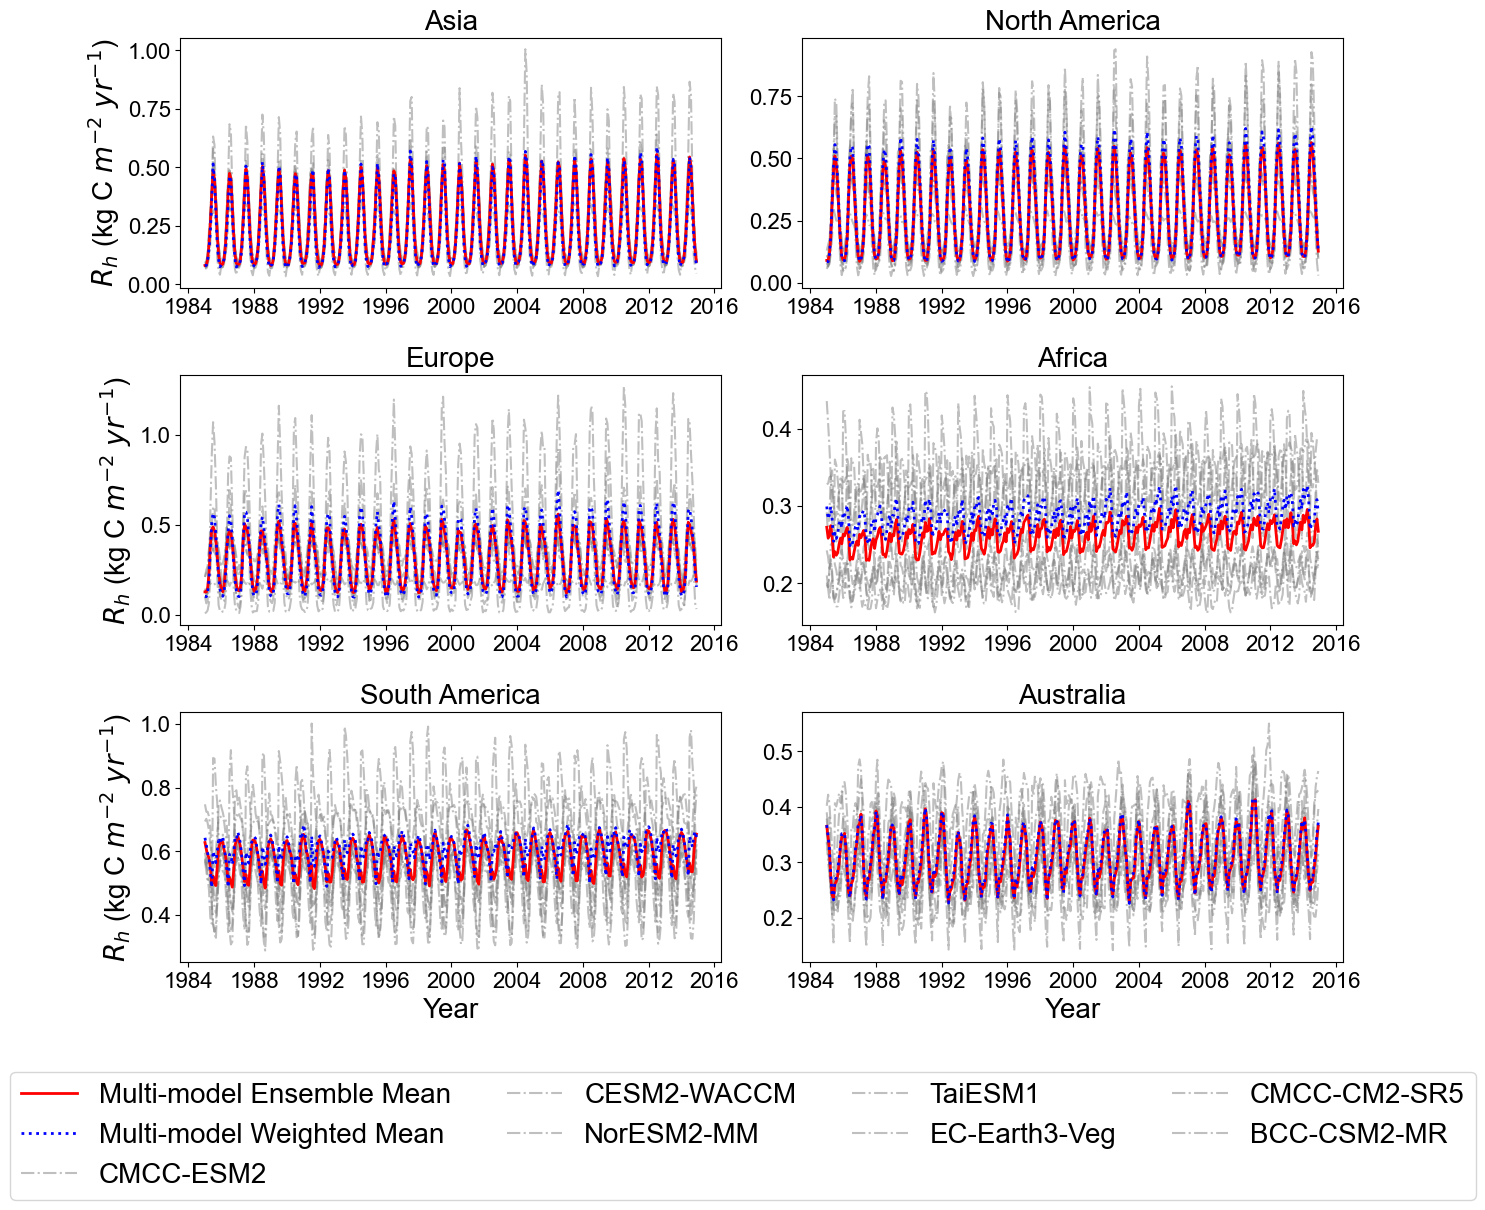

In [7]:
def create_supplementary_fig3():
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })
    # 创建图形和子图布局
    fig = plt.figure(figsize=(15, 12))
    for key, value in dict(CONTINENT_DICT).items():
        # 创建m×n的子图布局（根据实际需求调整）
        gs = gridspec.GridSpec(3, 2, figure=fig)
        ax = fig.add_subplot(gs[value])
        plot_supplementary_fig3a(fig, ax, 'rh', key)
    # 添加图例
    handles = [
        plt.Line2D([], [], **MODEL_STYLES['MMEM']),
        plt.Line2D([], [], **MODEL_STYLES['MMWM']),
        # plt.Line2D([], [], **MODEL_STYLES['ERA5']),  # 如需观测数据可取消注释
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER'])
    ]
    labels = ['Multi-model Ensemble Mean', 'Multi-model Weighted Mean', 'CMCC-ESM2', 'CESM2-WACCM','NorESM2-MM', 'TaiESM1', 'EC-Earth3-Veg','CMCC-CM2-SR5', 'BCC-CSM2-MR']  # 如需观测数据可加 'ERA5'
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=20, frameon=True, bbox_to_anchor=(0.5, -0.1))
    plt.subplots_adjust(wspace=0.15, hspace=0.35)
    plt.show()

if __name__ == '__main__':
    create_supplementary_fig3()

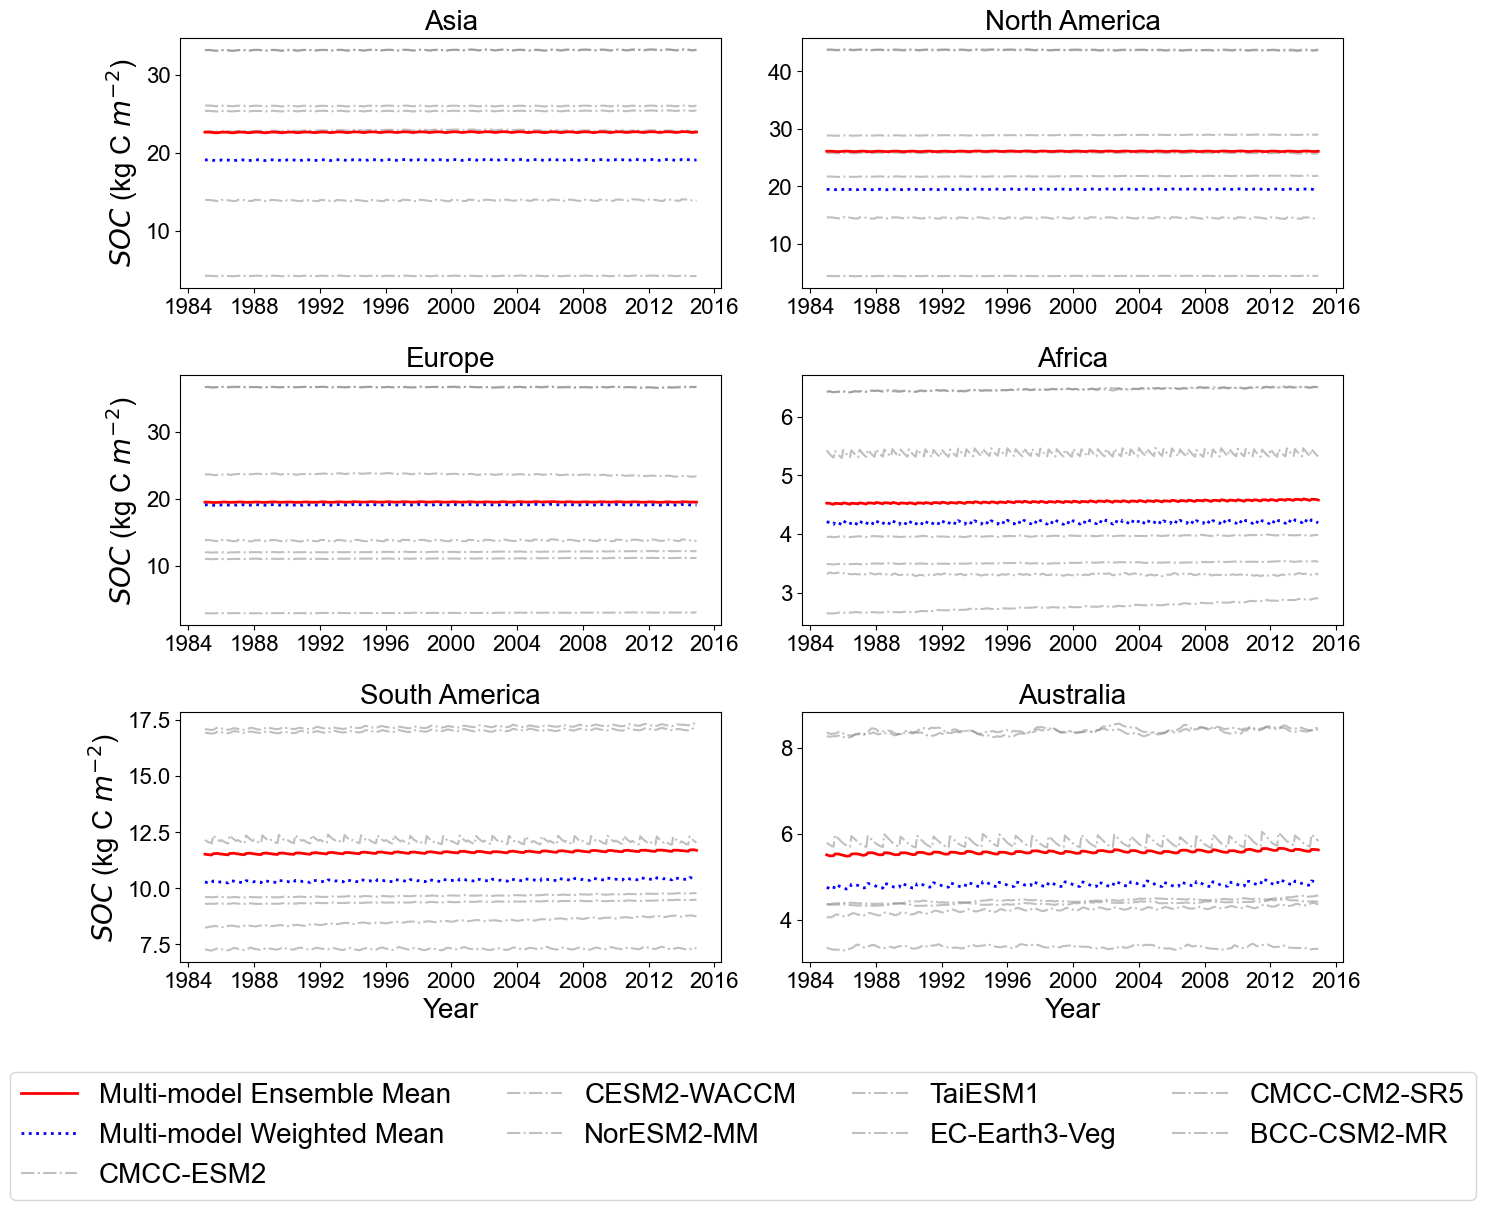

In [8]:
def create_supplementary_fig5():
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })
    # 创建图形和子图布局
    fig = plt.figure(figsize=(15, 12))
    for key, value in dict(CONTINENT_DICT).items():
        # 创建m×n的子图布局（根据实际需求调整）
        gs = gridspec.GridSpec(3, 2, figure=fig)
        ax = fig.add_subplot(gs[value])
        plot_supplementary_fig3a(fig, ax, 'soc', key)
    # 添加图例
    handles = [
        plt.Line2D([], [], **MODEL_STYLES['MMEM']),
        plt.Line2D([], [], **MODEL_STYLES['MMWM']),
        # plt.Line2D([], [], **MODEL_STYLES['ERA5']),  # 如需观测数据可取消注释
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER']),
        plt.Line2D([], [], **MODEL_STYLES['OTHER'])
    ]
    labels = ['Multi-model Ensemble Mean', 'Multi-model Weighted Mean', 'CMCC-ESM2', 'CESM2-WACCM','NorESM2-MM', 'TaiESM1', 'EC-Earth3-Veg','CMCC-CM2-SR5', 'BCC-CSM2-MR']  # 如需观测数据可加 'ERA5'
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=20, frameon=True, bbox_to_anchor=(0.5, -0.1))
    plt.subplots_adjust(wspace=0.15, hspace=0.35)
    plt.show()
    
if __name__ == '__main__':
    create_supplementary_fig5()